# Improving Classfication performance on STEAD dataset

In [1]:
from EQDataset import EQDataset
from NoiseDataset import NoiseDataset
import numpy as np
import torch 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import ConcatDataset, DataLoader, random_split
import pandas as pd
import h5py

from obspy.clients.fdsn import Client

from obspy import UTCDateTime

import seisbench.models as sbm

from phasenet import PhaseNet


In [2]:
csv_file_eq = '..//data//chunk5.csv'
file_name_eq = '..//data//chunk5.hdf5'

csv_file_noise = '..//data//chunk1.csv'
file_name_noise = '..//data//chunk1.hdf5'

Structure of the dataset: \
We want earthquakes and noise waves to appear in the same dataset, this shouldnt be separated

In [30]:
batch_size = 256

In [32]:
cl = 136
eq_dataset = EQDataset(csv_file_eq, file_name_eq, tri_width=10, transform=True, cutting_length=cl)
noise_dataset = NoiseDataset(csv_file_noise, file_name_noise, transform=True, cutting_length=cl)

datasets = [eq_dataset, noise_dataset]

dataset = ConcatDataset(datasets)

train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7,0.15, 0.15])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=10)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

5min 2500
1min 610 (3050)
8 workers 1min (with 10sec init) 1390
10 workers 1min (with 10sec init) 1450

In [35]:
# Initialize default parameters
epochs = 10
learning_rate = 3e-2

# Initialize datasets and dataloaders
train_loader = train_dataloader

# Initialize the model and optimizer
device = torch.device("mps")
model = PhaseNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction = 'sum')  # Replace with your loss function

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, logits=True)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().detach().numpy() / inputs.shape[0]
        if (not i%250):
            print(i, train_loss) 
            
    print(f"End of Epoch Training loss {train_loss / len(train_dataloader)}")
            
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)
            outputs = model(inputs, logits=True)
            val_loss += criterion(outputs, labels) / inputs.shape[0]
        
        print(f'Validation loss for epoch {epoch}: ', val_loss / len(val_dataloader))
        

In [43]:
import sys
sys.path.append("../")
from models.PhaseNet import PhaseNetL

In [69]:
robertmodel = torch.load("../classification_tolga/phasenet_15epochs.pt")

In [90]:
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=1)

In [111]:
batch_size = 64

In [112]:
num_waves = batch_size*8
nlength = 6000 - cl

raw_wave = torch.empty(num_waves, nlength)
raw_labels = torch.empty(num_waves, 3, nlength)
preds = torch.empty(num_waves, 3, nlength)

In [114]:
raw_wave[batch_size*i:batch_size*(i+1)].shape

torch.Size([64, 5864])

In [116]:
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        if i == 8: break
        raw_wave[batch_size*i:batch_size*(i+1)] = inputs
        raw_labels[batch_size*i:batch_size*(i+1)] = labels
        preds[batch_size*i:batch_size*(i+1)] = f.softmax(robertmodel(inputs), dim=1)

torch.Size([64, 5864])
torch.Size([64, 5864])
torch.Size([64, 5864])
torch.Size([64, 5864])
torch.Size([64, 5864])
torch.Size([64, 5864])
torch.Size([64, 5864])
torch.Size([64, 5864])


In [312]:
preds.shape

torch.Size([512, 3, 5864])

In [93]:
num_plots = 3; i = 0; j = 1;
raw_labels[num_plots*i+j][0].detach().numpy().argmax()

689

In [302]:
def get_preds(model, wave_tensor, num_waves, eq = False):
    preds = torch.empty(num_waves, 3, 6000)
    pick_preds = torch.empty(num_waves, 3)
    
    for i in range(num_waves):
        if (eq): preds[i] = torch.concat(model(wave_tensor[i].unsqueeze(0)))[[1, 2, 0], :]
        else: preds[i] = model(wave_tensor[i].unsqueeze(0))
        pick_preds[i, 0] = preds[i][0].argmax()
        pick_preds[i, 1] = preds[i][1].argmax()
        
        
    return preds, pick_preds

def plot_preds(raw, preds, labels, num_plots, offset = 0, figsize=(20,10), noise=False):
    fig, ax = plt.subplots(num_plots, 1, figsize=figsize, sharex=True)
    plt.tick_params(axis='both', which='major', labelsize=12)
    legend = ['Wave (Z)', 'P-Prediction', 'S-Prediction']
    fig.text(0.07, 0.5, 'Probability', va='center', rotation='vertical', fontsize=20)
    ymin, ymax = 0, 1
    j = 0
    cutoff = 3000
    x = np.arange(cutoff)/100
    for i in range(num_plots):
        #for j in range(num_plots):
        idx = offset + num_plots*i + j
        cur_ax = ax[i]
        cur_ax.tick_params(labelsize=15)
        
        p_pick = labels[idx][0].detach().numpy().argmax()
        s_pick = labels[idx][1].detach().numpy().argmax()
        
        if (p_pick != 0 and s_pick != 0):
            cur_ax.plot(x, (raw[idx]/(raw[idx].abs().max())-raw[idx].min())[:cutoff], color = 'gray', alpha=0.4)
            cur_ax.vlines(p_pick/100, ymin, ymax, color='tab:red', linestyle='--', linewidth=2, alpha=0.4, label='P-arrival')
            cur_ax.vlines(s_pick/100, ymin, ymax, color='tab:blue', linestyle='--', linewidth=2, alpha=0.4, label='S-arrival')
        else:
            cur_ax.plot(x, (raw[idx]/(raw[idx].abs().max())-raw[idx].min())[:cutoff], color = 'gray', alpha=0.4)
        legend = ['Wave (Z)', 'P-Pick', 'S-Pick', 'P-Prediction', 'S-Prediction']
            
        cur_ax.plot(x, preds[idx][0][:cutoff].detach().numpy(), linewidth=1, color='tab:red')
        cur_ax.plot(x, preds[idx][1][:cutoff].detach().numpy(), linewidth=1, color='tab:blue')
        #ax[i][j].plot(preds[num_plots*i+j][2].detach().numpy(), linewidth=1)
        cur_ax.legend(legend, loc = 'upper right')
    plt.ylim(ymin-0.1,ymax)
        
    ax[2].set_xlabel('Time (s)', fontsize = 20)
    

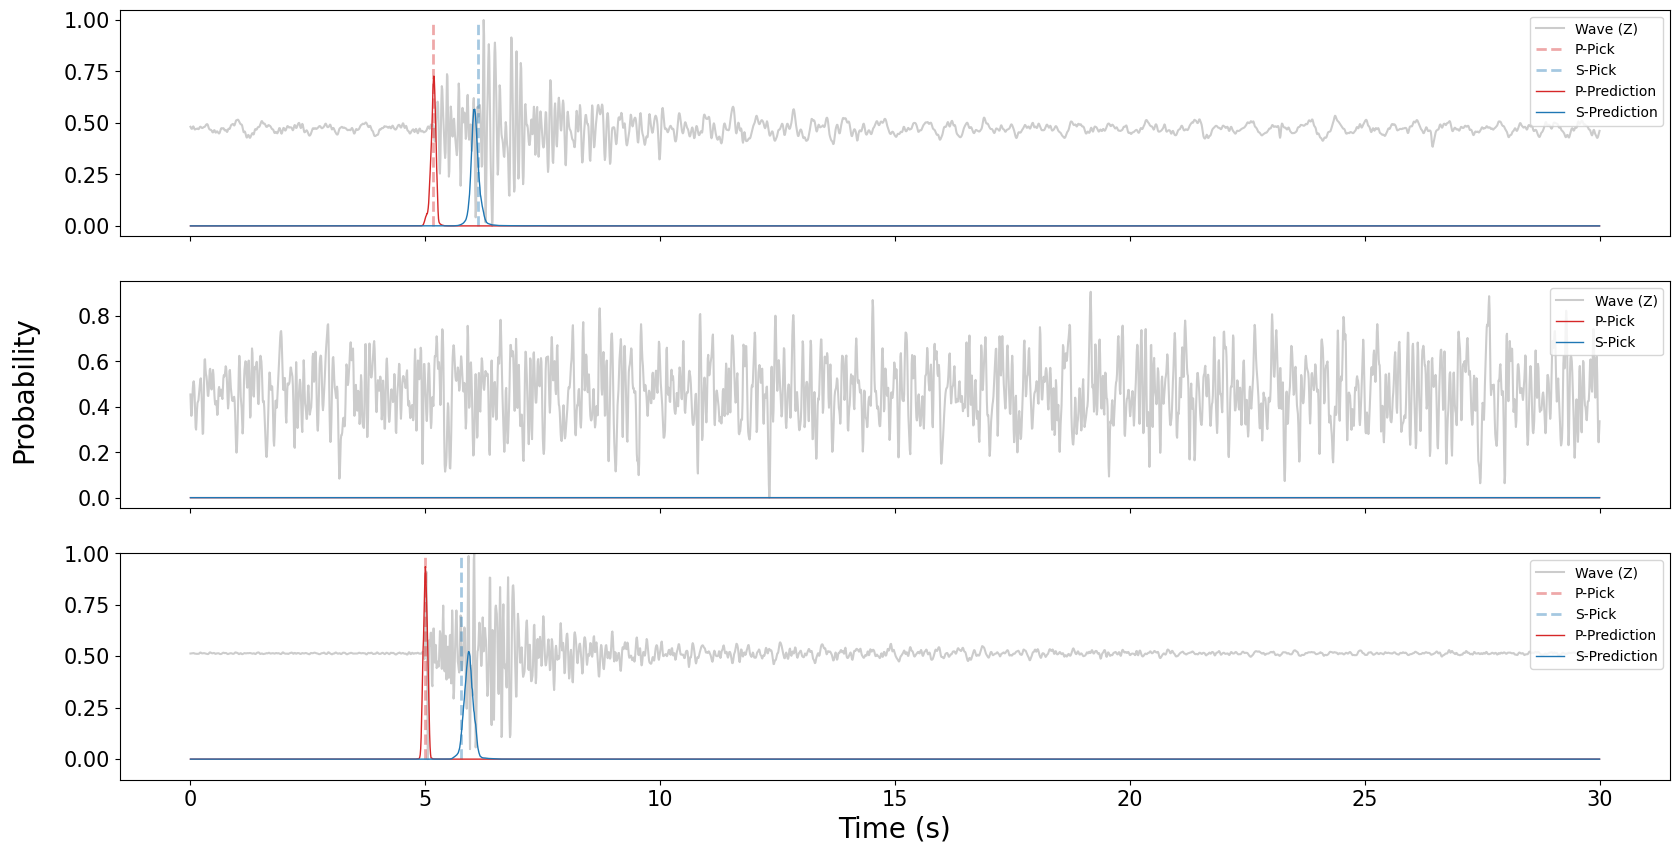

In [303]:
plot_preds(raw_wave, preds, raw_labels, 3, offset = 240)

In [344]:
preds_maxs

tensor([[2.7576e-05, 3.7890e-05, 1.0000e+00],
        [2.9225e-01, 8.5796e-02, 1.0000e+00],
        [8.7682e-01, 5.4426e-01, 1.0000e+00],
        ...,
        [5.8974e-01, 2.2414e-01, 1.0000e+00],
        [8.3947e-01, 2.3619e-01, 1.0000e+00],
        [4.1541e-01, 1.3745e-01, 1.0000e+00]])

In [142]:
preds_maxs = (preds.max(axis = 2))[0]

In [314]:
lmax, largmax = raw_labels.max(axis=2)

In [393]:
#largmax[:, 0]
noise_mask = largmax[:, 0] == 0

In [321]:
raw_labels[largmax[:, 0] == 0].shape

torch.Size([273, 3, 5864])

In [353]:
preds_maxs_eq = preds_maxs[~noise_mask][:, 0:2]
preds_maxs_noise = preds_maxs[noise_mask][:, 0:2]

In [374]:
theta = best_threshold(preds_maxs_eq, preds_maxs_noise)

In [386]:
precision_recall(preds_maxs_eq, preds_maxs_noise, theta), f1score(preds_maxs_eq, preds_maxs_noise, theta)

((tensor(0.9694), tensor(0.9937)), tensor(0.9814))

In [380]:
a, b = roc_rates(preds_maxs_eq, preds_maxs_noise)

In [397]:
picks = largmax[:, 0:2]
preds_pick = (preds.max(axis = 2))[1]

In [435]:
p_preds_eq[2, l:r].max()

tensor(1.2498e-09)

In [ ]:
p_preds_eq = preds[:, 0, :][~noise_mask]
p_preds_noise = preds[:, 0, :][noise_mask]

s_preds_eq = preds[:, 1, :][~noise_mask]
s_preds_noise = preds[:, 1, :][noise_mask]

In [ ]:
window_roc_rates(p_preds_eq, p_preds_noise, picks[~noise_mask, 0])

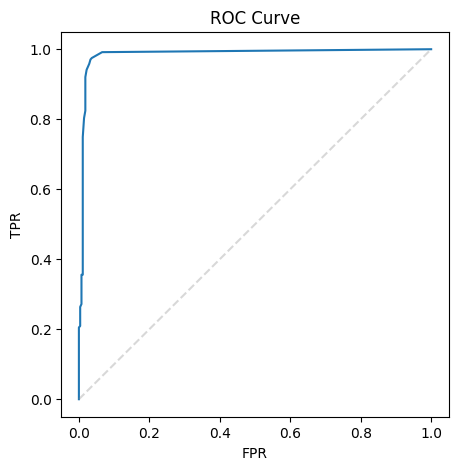

In [486]:
window_roc_curve(s_preds_eq, s_preds_noise, picks[~noise_mask, 1], num_thetas=100)

In [485]:
def window_roc_rates(eq_preds, noise_preds, picks, num_thetas = 100, window=10):
    true_positives = np.zeros(num_thetas)
    false_positives = np.zeros(num_thetas)
    false_negatives = np.zeros(num_thetas)
    true_negatives = np.zeros(num_thetas)
    
    for i, theta in enumerate(np.linspace(0,1,num_thetas)):
        for j in range(len(eq_preds[:,0])):
            l = max(picks[j]-window, 0); r = max(picks[j]+window,1)
            max_in_window = eq_preds[j, l:r].max()
            true_positives[i] += (max_in_window > theta).sum()
            false_negatives[i] += (max_in_window < theta).sum()
        
    for i, theta in enumerate(np.linspace(0,1,num_thetas)):
        
        false_positives[i] = (noise_preds.max(axis=1)[0] > theta).sum()
        true_negatives[i] = (noise_preds.max(axis=1)[0] < theta).sum()
        
        
    # TPR, FPR
    return true_positives / (true_positives+false_negatives), false_positives / (false_positives + true_negatives)

def window_roc_curve(preds_maxs_eq, preds_maxs_noise, picks, num_thetas=100, ax=None):
    tpr_p, fpr_p = window_roc_rates(preds_maxs_eq, preds_maxs_noise, picks, num_thetas=num_thetas, window=100)
    #tpr_s, fpr_s = window_roc_rates(preds_maxs_eq[1], preds_maxs_noise[1], picks, num_thetas=num_thetas)
    
    if ax == None: fig, ax = plt.subplots(1,1, figsize=(5, 5))
    
    ax.plot(fpr_p, tpr_p)
    #ax.plot(fpr_s, tpr_s)
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), color = 'gray', linestyle='--', alpha=0.3) # Diagonal
    ax.title.set_text('ROC Curve')
    ax.set(xlabel='FPR', ylabel='TPR')
    #ax.legend(['P', 'S'])
    
def roc_rates(eq_vec, noise_vec, num_thetas = 100):
    true_positives = np.empty(num_thetas)
    false_positives = np.empty(num_thetas)
    false_negatives = np.empty(num_thetas)
    true_negatives = np.empty(num_thetas)
    
    for i, theta in enumerate(np.linspace(0,1,num_thetas)):
        true_positives[i] = (eq_vec > theta).sum()
        
    for i, theta in enumerate(np.linspace(0,1,num_thetas)):
        false_positives[i] = (noise_vec > theta).sum()
        
    for i, theta in enumerate(np.linspace(0,1,num_thetas)):
        false_negatives[i] = (eq_vec < theta).sum()
        
    for i, theta in enumerate(np.linspace(0,1,num_thetas)):
        true_negatives[i] = (noise_vec < theta).sum()
        
        
    # TPR, FPR
    return true_positives / (true_positives+false_negatives), false_positives / (false_positives + true_negatives)

def precision_recall(eq_vec, noise_vec, theta):
    
    true_positives = (eq_vec > theta).sum()
        
    false_positives = (noise_vec > theta).sum()
    
    false_negatives = (eq_vec < theta).sum()
    
    #  precision, recall
    return true_positives / (true_positives+false_positives), true_positives / (true_positives + false_negatives)

def f1score(eq_vec, noise_vec, theta):
    precision, recall = precision_recall(eq_vec, noise_vec, theta)
    return 2*precision*recall / (precision + recall)

def best_threshold(eq_vec, noise_vec, num_thetas=100):
    best_f1 = 0
    best_theta = 0
    for i, theta in enumerate(np.linspace(0,1,num_thetas)):
        f1 = f1score(eq_vec, noise_vec, theta)
        if f1 > best_f1: 
            best_theta = theta
            best_f1 = f1
    
    return best_theta
        

def roc_curve(preds_maxs_eq, preds_maxs_noise, num_thetas=100, ax=None):
    tpr_p, fpr_p = window_roc_rates(preds_maxs_eq[0], preds_maxs_noise[0], num_thetas=num_thetas)
    tpr_s, fpr_s = window_roc_rates(preds_maxs_eq[1], preds_maxs_noise[1], num_thetas=num_thetas)
    
    if ax == None: fig, ax = plt.subplots(1,1, figsize=(5, 5))
    
    ax.plot(fpr_p, tpr_p)
    ax.plot(fpr_s, tpr_s)
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), color = 'gray', linestyle='--', alpha=0.3) # Diagonal
    ax.title.set_text('ROC Curve')
    ax.set(xlabel='FPR', ylabel='TPR')
    ax.legend(['P', 'S'])
    
    
def plot_confusion_matrix(preds_maxs_eq, preds_maxs_noise, theta):
    y_pred = torch.concat(((preds_maxs_eq > theta), (preds_maxs_noise > theta)))
    y_true = torch.concat((torch.ones(len(preds_maxs_eq)), torch.zeros(len(preds_maxs_noise))))
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    return disp

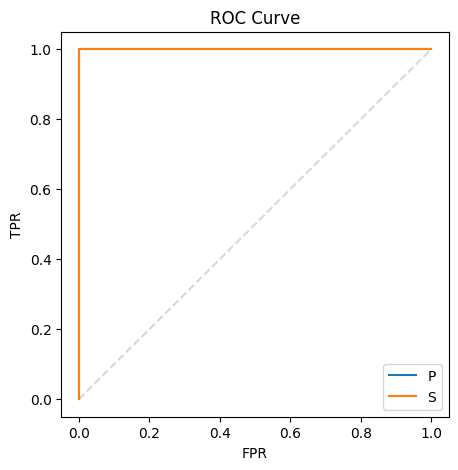

In [383]:
roc_curve(preds_maxs_eq, preds_maxs_noise)

In [51]:
import torch.nn.functional as f

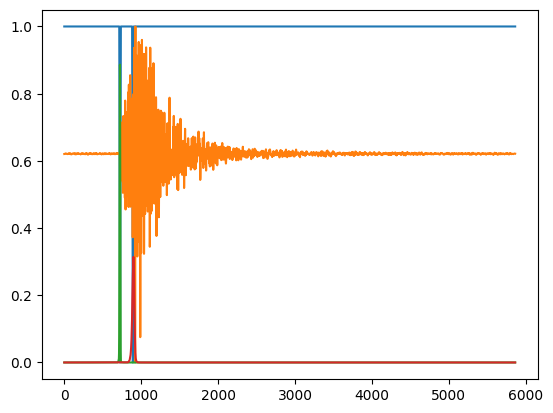

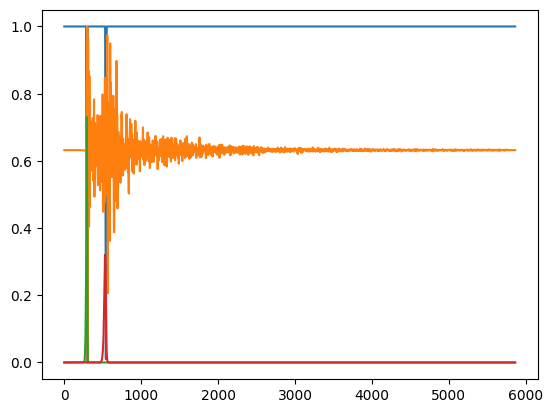

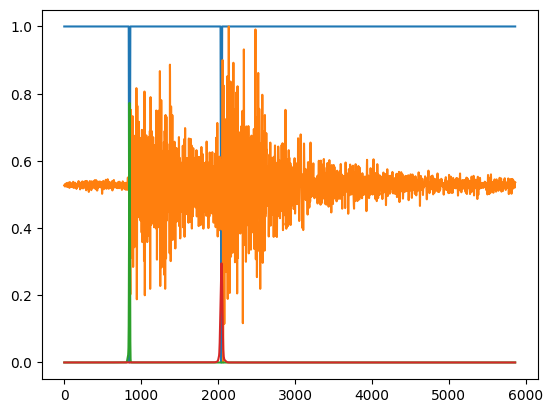

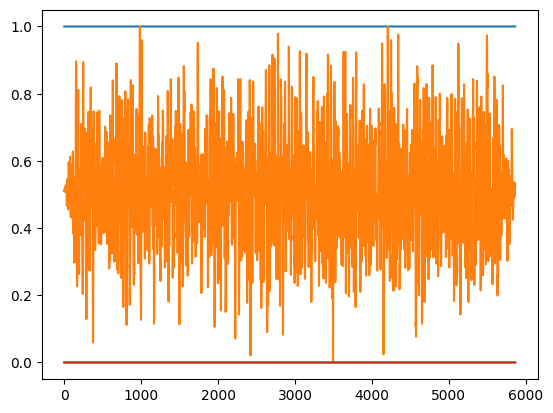

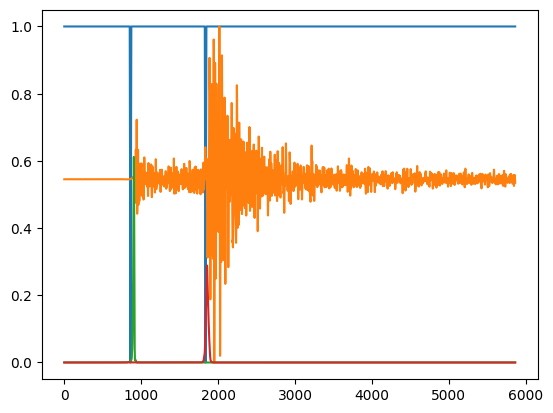

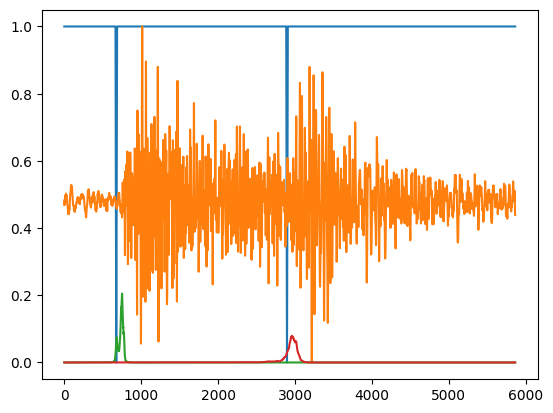

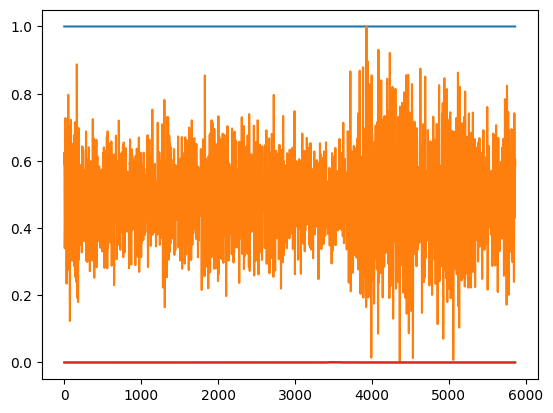

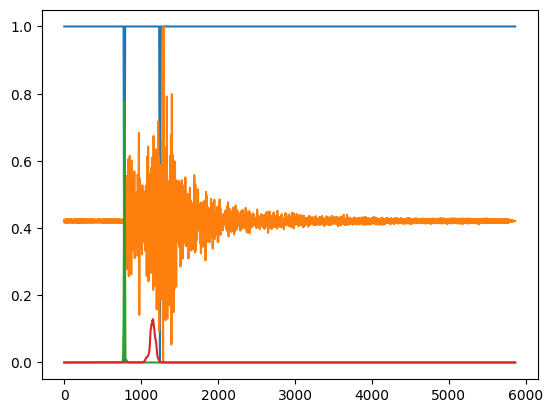

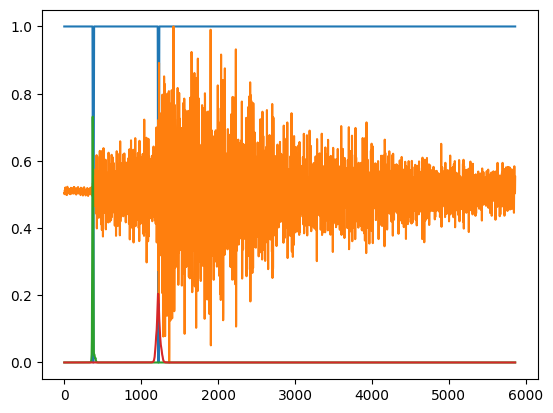

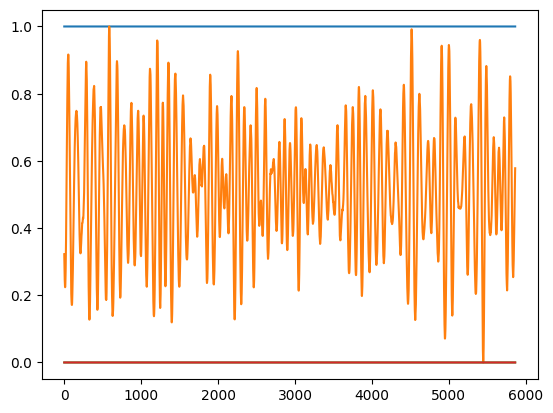

In [61]:
val_loss = 0
batch_num = 2
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        if (i > 0):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = f.softmax(robertmodel.forward(inputs), dim=1)
            plt.plot(labels.cpu().detach().numpy()[batch_num, 2, :])
            plt.plot(inputs.cpu().detach().numpy()[batch_num, :])
            plt.plot(outputs.cpu().detach().numpy()[batch_num,0,:])
            plt.plot(outputs.cpu().detach().numpy()[batch_num,1,:])
            #val_loss += criterion(outputs, labels) / inputs.shape[0]
            plt.show()
            if (i == 10): break
    
    #print(f'Validation loss for epoch {0}: ', val_loss / len(val_dataloader))

In [29]:
val_loss = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs
        outputs = pt_model(inputs)
        plt.plot(inputs.detach().numpy()[0, 0, :])
        plt.plot(outputs.detach().numpy()[0,0,:])
        plt.plot(outputs.detach().numpy()[0,1,:])
        #val_loss += criterion(outputs, labels) / inputs.shape[0]
        
        break

RuntimeError: Given groups=1, weight of size [8, 3, 7], expected input[64, 1, 6000] to have 3 channels, but got 1 channels instead